In [1]:
import pandas as pd
import numpy as np
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns

### DataLoad 

In [2]:
df = pd.read_csv('House_data.csv')

In [3]:
df.head()

,rooms,square,floor,total_floor,metro_station,time_to_metro,transport,price
0,2,67.0,4,24,козья_слобода,4,транспорте,14047176
1,1,48.0,4,24,козья_слобода,4,транспорте,11861624
2,3,107.0,7,24,козья_слобода,4,транспорте,23689091
3,2,61.0,4,21,козья_слобода,4,транспорте,15053000
4,1,42.0,2,21,козья_слобода,4,транспорте,11224000


In [4]:
df.describe()

,rooms,square,floor,total_floor,time_to_metro,price
count,815.000000,815.000000,815.000000,815.000000,815.000000,8.150000e+02
mean,1.988957,59.476074,6.260123,13.321472,10.649080,1.012623e+07
std,0.840396,27.894926,5.377044,6.476358,7.013469,5.972254e+06
min,1.000000,10.000000,1.000000,2.000000,1.000000,1.490000e+06
25%,1.000000,41.000000,2.000000,9.000000,4.000000,6.064500e+06
50%,2.000000,55.000000,4.000000,10.000000,9.000000,8.790901e+06
75%,3.000000,74.000000,9.000000,19.000000,18.000000,1.187581e+07
max,4.000000,458.000000,25.000000,26.000000,35.000000,4.331040e+07


# Data cleaning & Feature Engineering

In [5]:
#Сразу виден выброс с площадью(400 м^2)
df.drop(df['square'].argmax(), inplace=True)

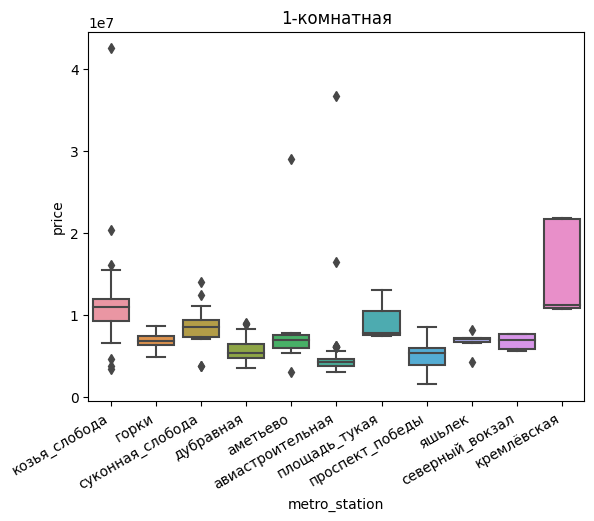

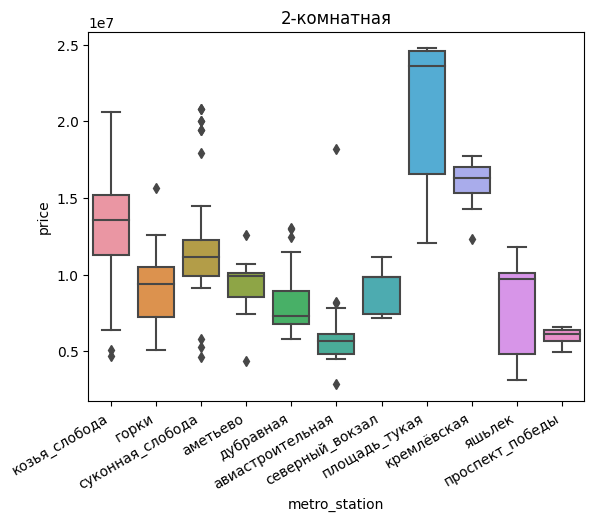

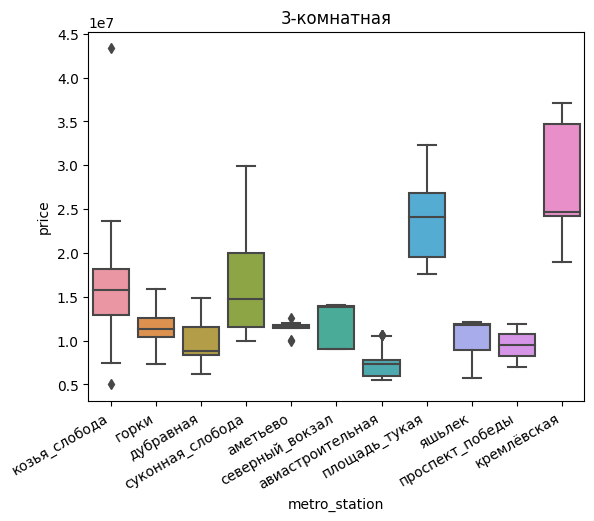

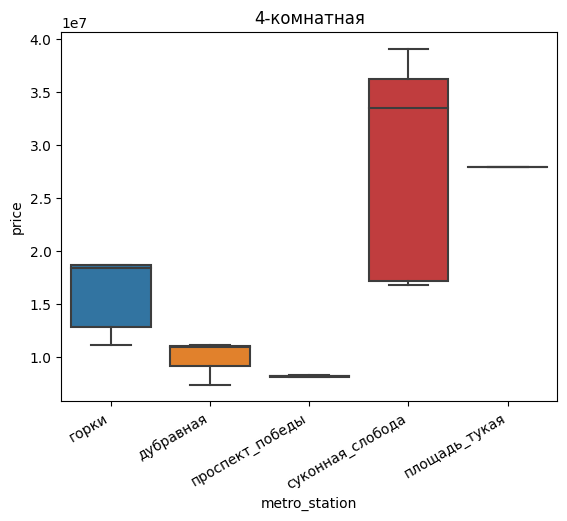

In [6]:
#Посмотрим как зависит цена квартир от района(метро) для всех типов квартир(количество комнат)
for i in range(1, 5):
    plt.title(f"{i}-комнатная")
    ax = sns.boxplot(x='metro_station', y='price', data=df[df['rooms'] == i])
    ax.set_xticklabels(ax.get_xticklabels(),rotation=30,ha='right')
    plt.show()

Видно, что цены около станций: Козья слобода, Кремлёвская, и Площадь Тукая явно выше(довольно логично, т.к эти станции в центре города)

<AxesSubplot: xlabel='square', ylabel='price'>

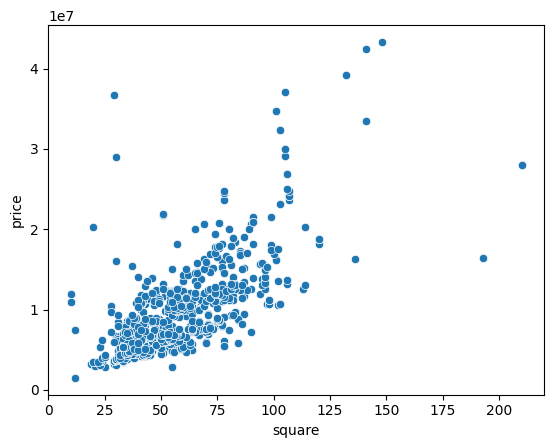

In [7]:
#Строим график зависимости цены квартиры от её площади
sns.scatterplot(data=df, x='square', y='price')

In [8]:
#Думаю, можно сделать колонку этаж/макс этаж и площадь/комнаты
df['floor_coef'] = df['floor'] / df['total_floor']
df['square_room'] = df['square'] / df['rooms']


In [9]:
df.drop(df['square'].argmax())

,rooms,square,floor,total_floor,metro_station,time_to_metro,transport,price,floor_coef,square_room
0,2,67.0,4,24,козья_слобода,4,транспорте,14047176,0.166667,33.500000
1,1,48.0,4,24,козья_слобода,4,транспорте,11861624,0.166667,48.000000
2,3,107.0,7,24,козья_слобода,4,транспорте,23689091,0.291667,35.666667
3,2,61.0,4,21,козья_слобода,4,транспорте,15053000,0.190476,30.500000
4,1,42.0,2,21,козья_слобода,4,транспорте,11224000,0.095238,42.000000
...,...,...,...,...,...,...,...,...,...,...
810,1,40.0,3,16,горки,8,транспорте,6990000,0.187500,40.000000
811,1,43.0,1,10,горки,8,транспорте,7383415,0.100000,43.000000
812,3,80.0,16,17,авиастроительная,8,пешком,7500000,0.941176,26.666667
813,2,58.0,1,24,авиастроительная,20,транспорте,7586140,0.041667,29.000000


# Extracting Training Data

In [10]:
X = df.drop('price', axis=1)
y = df['price']

In [11]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3)

# Encodind

In [12]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import make_column_transformer
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_squared_error
# Закодируем категориальные признак с помощью OneHotEncoder
one_hot_encoder=OneHotEncoder()
one_hot_encoder.fit(X[['metro_station','transport']])

OneHotEncoder()

In [13]:
# Преобразуем колонки
new_columns = make_column_transformer((OneHotEncoder(categories=one_hot_encoder.categories_),['metro_station', 'transport']),
                                remainder='passthrough')

# Building model

In [14]:
# сначала попробуем pipeline для линейной регрессии
lr = LinearRegression()
pipe_line = make_pipeline(new_columns, lr)
pipe_line.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('onehotencoder',
                                                  OneHotEncoder(categories=[array(['авиастроительная', 'аметьево', 'горки', 'дубравная',
       'козья_слобода', 'кремлёвская', 'площадь_тукая', 'проспект_победы',
       'северный_вокзал', 'суконная_слобода', 'яшьлек'], dtype=object),
                                                                            array(['пешком', 'транспорте'], dtype=object)]),
                                                  ['metro_station',
                                                   'transport'])])),
                ('linearregression', LinearRegression())])

In [15]:
y_pred = pipe_line.predict(X_test)
y_pred[0]

17157079.43033094

In [16]:
from sklearn.metrics import mean_absolute_error

In [17]:
# Качество не очень
mean_absolute_error(y_pred, y_test)

1829600.9837432648

In [18]:
from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor()
rf_pipeline = make_pipeline(new_columns, rf)

rf_pipeline.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('onehotencoder',
                                                  OneHotEncoder(categories=[array(['авиастроительная', 'аметьево', 'горки', 'дубравная',
       'козья_слобода', 'кремлёвская', 'площадь_тукая', 'проспект_победы',
       'северный_вокзал', 'суконная_слобода', 'яшьлек'], dtype=object),
                                                                            array(['пешком', 'транспорте'], dtype=object)]),
                                                  ['metro_station',
                                                   'transport'])])),
                ('randomforestregressor', RandomForestRegressor())])

In [19]:
# Уже немного лучше
y_pred = rf_pipeline.predict(X_test)
mean_absolute_error(y_pred, y_test)

1110242.6724175252

In [20]:
from sklearn.ensemble import GradientBoostingRegressor
gb = GradientBoostingRegressor()
gb_pipeline = make_pipeline(new_columns, gb)

gb_pipeline.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('onehotencoder',
                                                  OneHotEncoder(categories=[array(['авиастроительная', 'аметьево', 'горки', 'дубравная',
       'козья_слобода', 'кремлёвская', 'площадь_тукая', 'проспект_победы',
       'северный_вокзал', 'суконная_слобода', 'яшьлек'], dtype=object),
                                                                            array(['пешком', 'транспорте'], dtype=object)]),
                                                  ['metro_station',
                                                   'transport'])])),
                ('gradientboostingregressor', GradientBoostingRegressor())])

In [21]:
# Пока лучше всего себя показал RandomForest => попробуем подобрать гиперпараметры
y_pred = gb_pipeline.predict(X_test)
mean_absolute_error(y_pred, y_test)

1262864.5536712757

In [22]:
from sklearn.model_selection import GridSearchCV
n_estimators = [100, 150, 200, 300, 500, 1000]
max_depth = [70, 90, 100, 110]
y_pred = rf_pipeline.predict(X_test)
min_score = mean_absolute_error(y_pred, y_test)
best_estimator = 100
best_depth = 0
for estimator in n_estimators:
    for depth in max_depth:
        rf = RandomForestRegressor(n_estimators=estimator, max_depth=depth)
        rf_pipeline = make_pipeline(new_columns, rf)
        rf_pipeline.fit(X_train, y_train)
        score = mean_absolute_error(y_test, rf_pipeline.predict(X_test))
        if score < min_score:
            best_depth = depth
            best_estimator = estimator
            min_score = score


In [23]:
# Оказалось, что начальные условия подходили лучше всего
print(min_score, ' : ', best_depth, ' : ', best_estimator)

1096945.1302961807  :  100  :  500


In [24]:
rf_pipeline = make_pipeline(new_columns, rf)

rf_pipeline.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('onehotencoder',
                                                  OneHotEncoder(categories=[array(['авиастроительная', 'аметьево', 'горки', 'дубравная',
       'козья_слобода', 'кремлёвская', 'площадь_тукая', 'проспект_победы',
       'северный_вокзал', 'суконная_слобода', 'яшьлек'], dtype=object),
                                                                            array(['пешком', 'транспорте'], dtype=object)]),
                                                  ['metro_station',
                                                   'transport'])])),
                ('randomforestregressor',
                 RandomForestRegressor(max_depth=110, n_estimators=1000))])

In [27]:
# Сохраняем модель
import joblib
joblib.dump(rf_pipeline, open('RFRegression.joblib', 'wb'))

